In [2]:
#region imports
from IPython import get_ipython

# noinspection PyBroadException
try:
    _magic = get_ipython().run_line_magic
    _magic("load_ext", "autoreload")
    _magic("autoreload", "2")
except:
    pass

# noinspection PyUnresolvedReferences
import datetime as dt
# noinspection PyUnresolvedReferences
import glob
# noinspection PyUnresolvedReferences
import os
# noinspection PyUnresolvedReferences
import pprint
# noinspection PyUnresolvedReferences
import sys
# noinspection PyUnresolvedReferences
import cartopy as crt
# noinspection PyUnresolvedReferences
import matplotlib as mpl
# noinspection PyUnresolvedReferences
import matplotlib.colors
# noinspection PyUnresolvedReferences
import matplotlib.pyplot as plt
# noinspection PyUnresolvedReferences
import numpy as np
# noinspection PyUnresolvedReferences
import pandas as pd
# noinspection PyUnresolvedReferences
import seaborn as sns
# noinspection PyUnresolvedReferences
import xarray as xr
# noinspection PyUnresolvedReferences
#import bnn_tools.bnn_array

plt.style.use('default')
xr.set_options(
    display_expand_data = False,
    display_expand_data_vars = True,
    display_max_rows = 10,
    display_style = 'html',
    display_width = 80,
    display_expand_attrs = False
);

from windrose import WindroseAxes, WindAxes, plot_windrose
#endregion

## open files

In [3]:
# Open files with information about the ranking
gg = './data/Difference_35_quantiles_g{}.csv'

In [4]:
dsg = []
for i in [1,2,3]:
    G = gg.format(i)
    g_ = (
        pd.read_csv(
        G, parse_dates=[1]
        )
        .assign(g=f'g{i}')
    )
    dsg.append(g_)
dsg = pd.concat(dsg)

dsg

,Unnamed: 0,Date,Ranking,quantiles,g
0,26,2022-05-27,58.063644,0.013889,g1
1,25,2022-05-26,107.546202,0.027778,g1
2,21,2022-04-23,157.124674,0.041667,g1
3,10,2022-06-11,176.395042,0.055556,g1
4,1,2022-04-03,215.907264,0.069444,g1
...,...,...,...,...,...
15,1,2022-05-02,1235.748057,0.944444,g3
16,11,2022-04-13,1310.720166,0.958333,g3
17,4,2022-06-05,1544.309968,0.972222,g3
18,21,2022-05-22,1959.127080,0.986111,g3


In [5]:
# Open meteorology files
dd = [
    './data/meteo032022.csv',
    './data/meteo042022.csv',
    './data/meteo052022.csv',
    './data/meteo062022.csv',
    ]

In [6]:
dds = []
for d in dd:
    D = d
    ds = (
        pd.read_csv(
            D,index_col=0, parse_dates=[0]
        )
        .assign(Date=lambda d:d.index.floor('D'))
    )
    dds.append(ds)
ds = pd.concat(dds)


In [7]:
# Merge Meteorology and ranking files 

ds0 = pd.merge(ds.reset_index(),dsg,left_on='Date',right_on='Date')

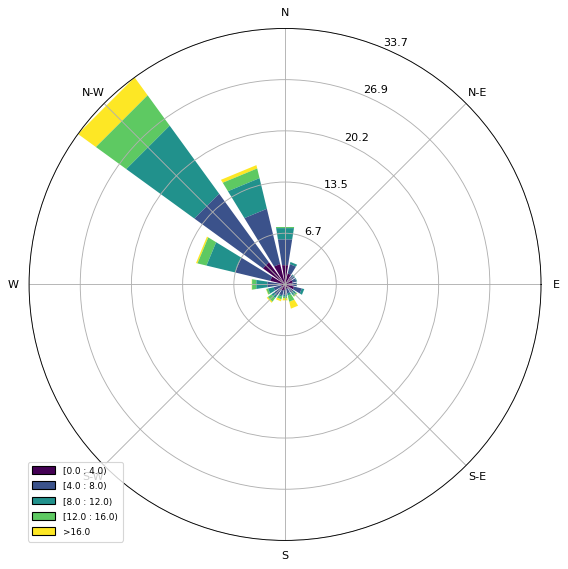

In [8]:
# plot a windrose using original direction and speed
ax = WindroseAxes.from_ax()

ax.bar(ds.dv1m.values,ds.vv1m.values, normed = True, bins=np.arange(0.01,20,4))
ax.set_legend()

Wind rose all days all times using original direction and speed

<AxesSubplot: xlabel='timestampx'>

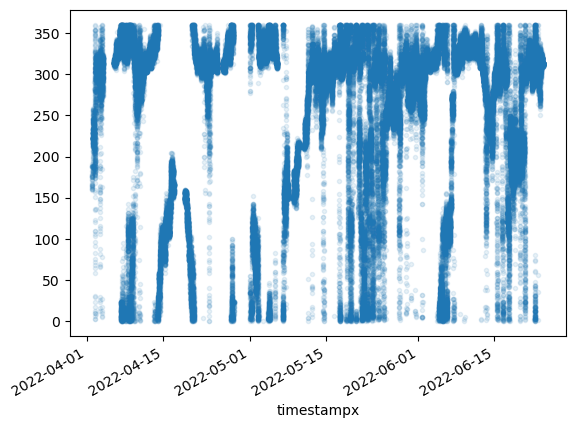

In [9]:
# plot time series of direction
ds0.set_index('timestampx')['dv1m'].plot(lw=0,marker='.',alpha=.1)

<AxesSubplot: xlabel='timestampx'>

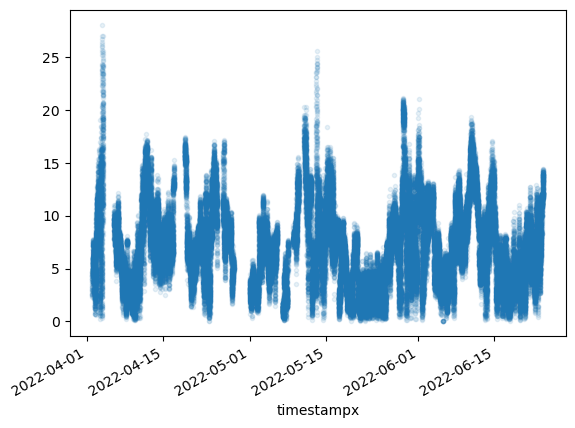

In [10]:
# Plot time series of wind speed
ds0.set_index('timestampx')['vv1m'].plot(lw=0,marker='.',alpha=.1)

In [11]:
# add x and y components of wind, hour, month, x and y in km/h and wind speed in km/h
ds1 = (
    ds0
    .assign(x=lambda d:d['vv1m'] * np.sin(d['dv1m'] * np.pi / 180.0))
    .assign(y=lambda d:d['vv1m'] * np.cos(d['dv1m'] * np.pi / 180.0))
    .assign(h = lambda d: d['timestampx'].dt.hour)
    .assign(m = lambda d: d['timestampx'].dt.month)
    .assign(xx= lambda d: d['x']*3.6)
    .assign(yy= lambda d: d['y']*3.6)
    .assign(vv= lambda d: d['vv1m']*3.6)
)

<AxesSubplot: xlabel='x', ylabel='y'>

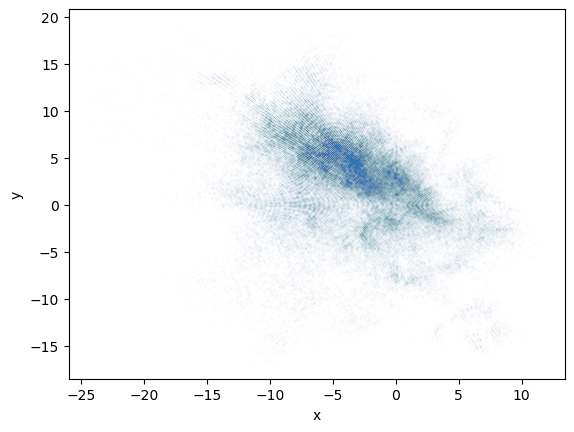

In [12]:
# plot x and y wind scatter plots 
(
    ds1

    .plot.scatter(
        'x','y',
        alpha=.05,
        marker='x',
        linewidth=.2,
        s = 2
    )
)

It seems that the artificial Artifacts are gone

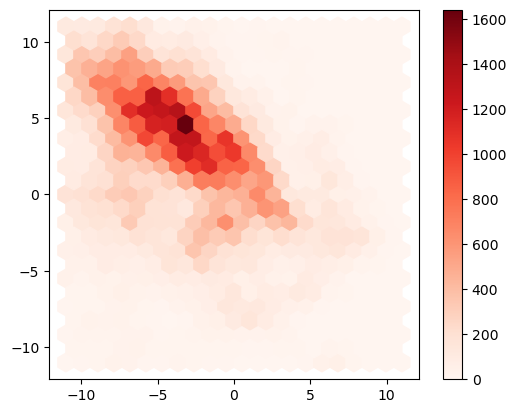

In [13]:
# same as above but using a hexbin plot 
f, ax = plt.subplots()
f:plt.Figure
ax: plt.Axes
a = 11
cc = (
    ax.hexbin(
        x=ds1['x'], y=ds1['y'],
        gridsize=21,
        cmap=plt.get_cmap('Reds'),
        extent=[-a,a,-a,a]
    )
)
ax.set_aspect('equal')
f.colorbar(cc,ax=ax)

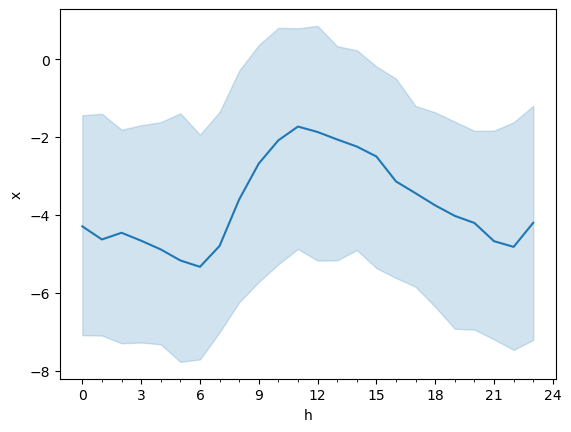

In [15]:
# x median and IQR 
(
    ds1
    .reset_index()
    .pipe(
        lambda d:
        sns.lineplot(
            x=d['h'],
            y=d['x'],
            estimator='median',
            errorbar=('pi', 50)
        )
          )
)
ax:plt.Axes = plt.gca()
ax.set_xticks(np.arange(0,25,3))
ax.set_xticks(np.arange(0,24,1),minor=True);

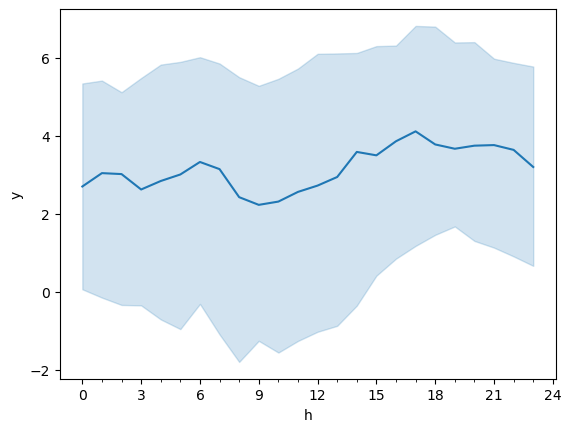

In [16]:
# y median and IQR 

(
    ds1
    .reset_index()
    .pipe(
        lambda d:
        sns.lineplot(
            x=d['h'],
            y=d['y'],
            estimator='median',
            errorbar=('pi', 50)
        )
    )
)
ax:plt.Axes = plt.gca()
ax.set_xticks(np.arange(0,25,3))
ax.set_xticks(np.arange(0,24,1),minor=True);


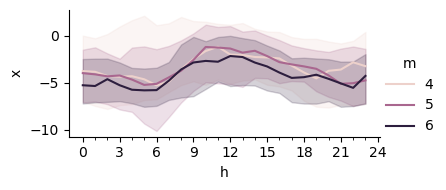

In [17]:
# plot x divided by months with IQR
(
    ds1
    .reset_index()
    .pipe(
        lambda d:
        sns.relplot(
            data = ds1,
            x='h',
            y='x',
            estimator='median',
            errorbar=('pi', 50),
            kind = 'line',
            # row = 'm',
            height = 2,
            aspect = 2,
            hue = 'm'
        )
    )
)
ax:plt.Axes = plt.gca()
ax.set_xticks(np.arange(0,25,3))
ax.set_xticks(np.arange(0,24,1),minor=True);

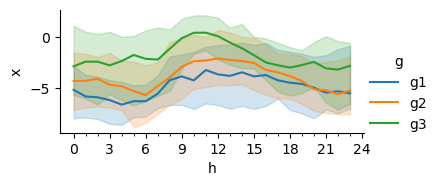

In [18]:
# plot x divided by g group 
(
    ds1
    .reset_index()
    .pipe(
        lambda d:
        sns.relplot(
            data = ds1,
            x='h',
            y='x',
            estimator='median',
            errorbar=('pi', 50),
            kind = 'line',
            # row = 'm',
            height = 2,
            aspect = 2,
            hue = 'g',
            hue_order=['g1','g2','g3']
        )
    )
)
ax:plt.Axes = plt.gca()
ax.set_xticks(np.arange(0,25,3))
ax.set_xticks(np.arange(0,24,1),minor=True);

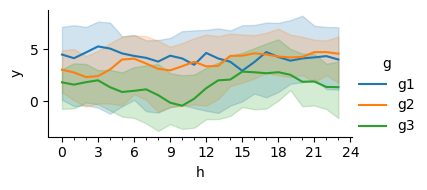

In [19]:
# plot y divided by g group 
(
    ds1
    .reset_index()
    .pipe(
        lambda d:
        sns.relplot(
            data = ds1,
            x='h',
            y='y',
            estimator='median',
            errorbar=('pi', 50),
            kind = 'line',
            # row = 'm',
            height = 2,
            aspect = 2,
            hue = 'g',
            hue_order=['g1','g2','g3']
        )
    )
)
ax:plt.Axes = plt.gca()
ax.set_xticks(np.arange(0,25,3))
ax.set_xticks(np.arange(0,24,1),minor=True);

In [20]:

ds2 = (
    ds1
    .groupby(['h','g','Date'])
    .median(numeric_only=False)
    .reset_index()
    .pipe(lambda d:d[d['h']==10])
)
ds2

,h,g,Date,timestampx,vv1m,dv1m,vmax1m,dmax1m,ta,hr,...,vis,Unnamed: 0,Ranking,quantiles,x,y,m,xx,yy,vv
720,10,g1,2022-04-03,2022-04-03 10:29:30,12.05,283.0,14.85,285.5,7.4,78.0,...,19444.5,1.0,215.907264,0.069444,-11.561490,3.101956,4.0,-41.621364,11.167043,43.38
721,10,g1,2022-04-12,2022-04-12 10:29:30,12.70,325.0,13.85,326.0,10.8,45.0,...,20000.0,10.0,347.467527,0.194444,-7.256603,10.476439,4.0,-26.123772,37.715180,45.72
722,10,g1,2022-04-14,2022-04-14 10:29:30,6.20,54.5,8.60,60.5,13.4,29.0,...,20000.0,12.0,251.314749,0.097222,4.928576,3.656451,4.0,17.742874,13.163223,22.32
723,10,g1,2022-04-15,2022-04-15 10:29:30,6.45,107.0,8.40,106.0,14.5,7.0,...,20000.0,13.0,228.605162,0.083333,5.919434,-1.789824,4.0,21.309961,-6.443365,23.22
724,10,g1,2022-04-19,2022-04-19 10:29:30,7.00,131.0,8.35,127.5,12.1,27.0,...,19757.5,17.0,367.221166,0.236111,5.243133,-4.205741,4.0,18.875279,-15.140669,25.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,10,g3,2022-06-06,2022-06-06 10:29:30,4.50,113.0,5.80,112.0,17.0,8.0,...,20000.0,5.0,934.269994,0.791667,4.109354,-1.809978,6.0,14.793675,-6.515921,16.20
788,10,g3,2022-06-13,2022-06-13 10:29:30,3.95,233.0,6.15,221.5,20.8,17.5,...,20000.0,12.0,984.959136,0.819444,-2.744495,-1.780494,6.0,-9.880184,-6.409777,14.22
789,10,g3,2022-06-14,2022-06-14 10:29:30,12.80,241.5,16.30,242.0,19.5,6.0,...,20000.0,13.0,931.941297,0.763889,-11.290360,-5.852415,6.0,-40.645295,-21.068694,46.08
790,10,g3,2022-06-16,2022-06-16 10:29:30,3.70,319.0,4.90,317.5,16.9,24.0,...,20000.0,15.0,1123.529101,0.902778,-2.116384,2.887763,6.0,-7.618983,10.395948,13.32


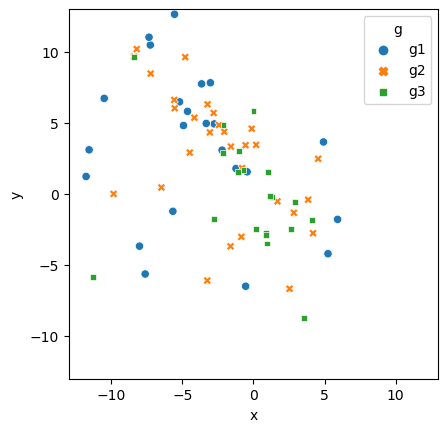

In [21]:
# Plot X And Y scatterplot
(
    ds2
    .reset_index()
    .pipe(
        lambda d:
        sns.scatterplot(
            data = d,
            x='x',
            y='y',
            # estimator='median',
            # errorbar=('pi', 50),
            # kind = 'scatter',
            # row = 'm',
            # height = 4,
            # aspect = 1,
            hue = 'g',
            hue_order=['g1','g2','g3'],
            style='g'
        )
    )
)
ax:plt.Axes = plt.gca()
k = 13
ax.set_ylim(-k,k)
ax.set_xlim(-k,k)
ax.set_aspect('equal')
# ax.set_xticks(np.arange(0,25,3))
# ax.set_xticks(np.arange(0,24,1),minor=True);

It seems that, in general, the winds for group G3 tend to be of lower speed. We had already seen this.

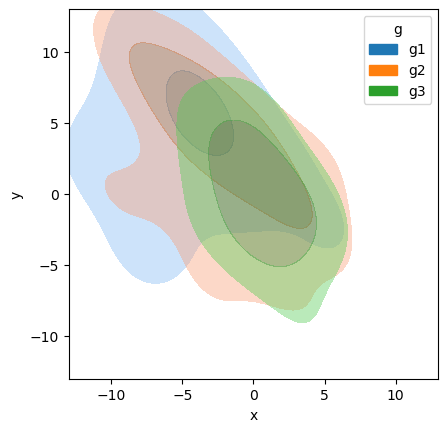

In [220]:
(
    ds2
    .reset_index()
    .pipe(
        lambda d:
        sns.kdeplot(
            data = d,
            x='x',
            y='y',
            # estimator='median',
            # errorbar=('pi', 50),
            # kind = 'scatter',
            # row = 'm',
            # height = 4,
            # aspect = 1,
            hue = 'g',
            hue_order=['g1','g2','g3'],
            # style='g',
            fill = True,
            levels = 3,
            thresh = .2,
            alpha=.4,
            # ls = '--',
            # edgecolors=4
            # edgewidth = 3

        )
    )
)
ax:plt.Axes = plt.gca()
k = 13
ax.set_ylim(-k,k)
ax.set_xlim(-k,k)
ax.set_aspect('equal')
# ax.set_xticks(np.arange(0,25,3))
# ax.set_xticks(np.arange(0,24,1),minor=True);

This graph is similar to the previous one. However, instead of plotting the individual values of X and Y, we plot the area where most of these values are located. In this case, the intense area corresponds to where 40% of the values are found. The less intense area corresponds to where 80% of the values are located.

(0.0, 40.0)

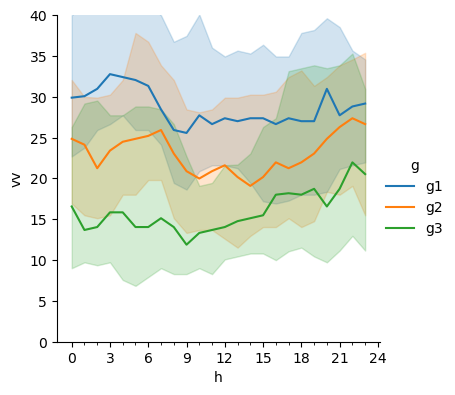

In [229]:
(
    ds1
    .reset_index()
    .pipe(
        lambda d:
        sns.relplot(
            data = ds1,
            x='h',
            y='vv',
            estimator='median',
            errorbar=('pi', 50),
            kind = 'line',
            # row = 'm',
            height = 4,
            aspect = 1,
            hue = 'g',
            hue_order=['g1','g2','g3']
        )
    )
)
ax:plt.Axes = plt.gca()
ax.set_xticks(np.arange(0,25,3))
ax.set_xticks(np.arange(0,24,1),minor=True);
ax.set_ylim(0,40)

This graph shows the speeds in kilometers per hour for each group G. It becomes clear again that for group G3 the speeds are almost half of those in group G1.

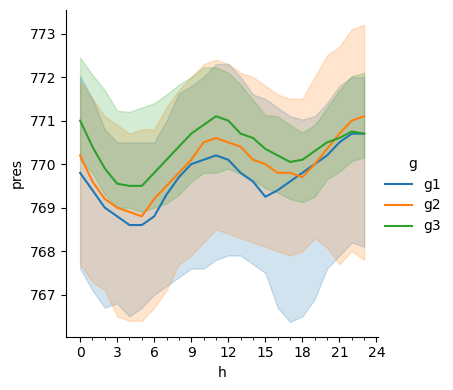

In [22]:
# same but for pressure 
(
    ds1
    .reset_index()
    .pipe(
        lambda d:
        sns.relplot(
            data = ds1,
            x='h',
            y='pres',
            estimator='median',
            errorbar=('pi', 50),
            kind = 'line',
            # row = 'm',
            height = 4,
            aspect = 1,
            hue = 'g',
            hue_order=['g1','g2','g3']
        )
    )
)
ax:plt.Axes = plt.gca()
ax.set_xticks(np.arange(0,25,3))
ax.set_xticks(np.arange(0,24,1),minor=True);
# ax.set_ylim(0,40)

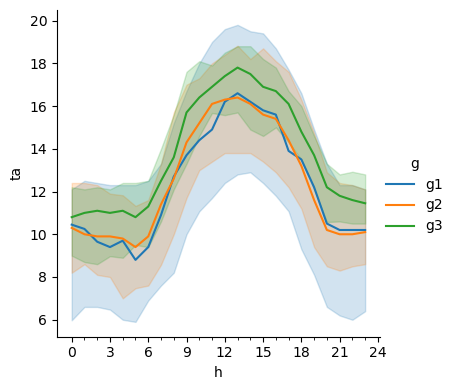

In [23]:
# same but for temperature
(
    ds1
    .reset_index()
    .pipe(
        lambda d:
        sns.relplot(
            data = ds1,
            x='h',
            y='ta',
            estimator='median',
            errorbar=('pi', 50),
            kind = 'line',
            # row = 'm',
            height = 4,
            aspect = 1,
            hue = 'g',
            hue_order=['g1','g2','g3']
        )
    )
)
ax:plt.Axes = plt.gca()
ax.set_xticks(np.arange(0,25,3))
ax.set_xticks(np.arange(0,24,1),minor=True);
# ax.set_ylim(0,40)

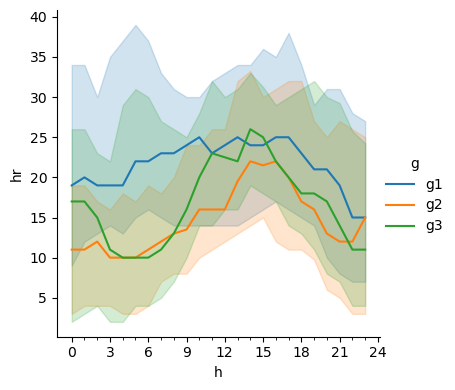

In [24]:
# same for HR 
(
    ds1
    .reset_index()
    .pipe(
        lambda d:
        sns.relplot(
            data = ds1,
            x='h',
            y='hr',
            estimator='median',
            errorbar=('pi', 50),
            kind = 'line',
            # row = 'm',
            height = 4,
            aspect = 1,
            hue = 'g',
            hue_order=['g1','g2','g3']
        )
    )
)
ax:plt.Axes = plt.gca()
ax.set_xticks(np.arange(0,25,3))
ax.set_xticks(np.arange(0,24,1),minor=True);
# ax.set_ylim(0,40)

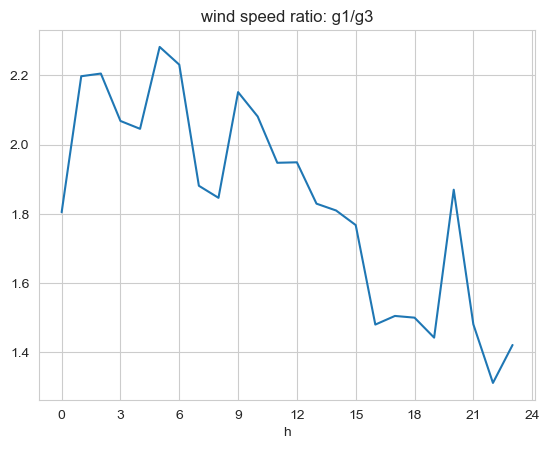

In [247]:
(
    ds1
    [['vv','g','h']]
    .groupby(['h','g'])
    .median()
    .unstack()
    ['vv']
    .pipe(lambda d: d['g1']/d['g3'])
    .plot()
)
ax:plt.Axes = plt.gca()
ax.set_title('wind speed ratio: g1/g3')
ax.set_xticks(np.arange(0,25,3))
ax.set_xticks(np.arange(0,24,1),minor=True);

The following graph shows the ratio between the speed of group G1 and group G3. It can be seen that, in general, the speed of G1 is twice that of G3.

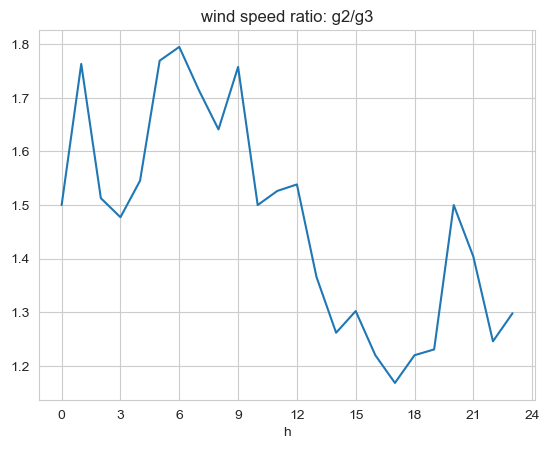

In [248]:
(
    ds1
    [['vv','g','h']]
    .groupby(['h','g'])
    .median()
    .unstack()
    ['vv']
    .pipe(lambda d: d['g2']/d['g3'])
    .plot()
)
ax:plt.Axes = plt.gca()
ax.set_title('wind speed ratio: g2/g3')
ax.set_xticks(np.arange(0,25,3))
ax.set_xticks(np.arange(0,24,1),minor=True);

We can do the same exercise for the ratio between g2 and g3 . The result is that, in general, the speed of G2 is 1.5 times faster than that of G3.

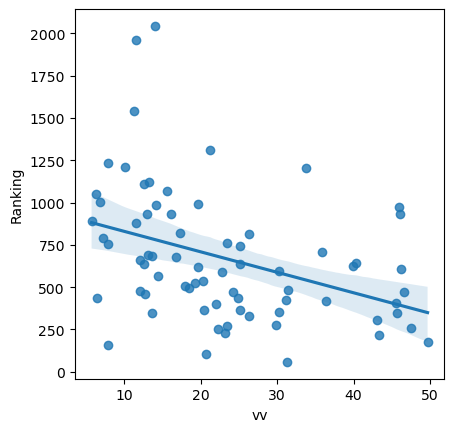

In [30]:
sns.regplot(
    data = ds2,
    x = 'vv',
    y = 'Ranking'
)
ax:plt.Axes = plt.gca()
# ax.set_yscale('log')
ax.set_box_aspect(1)

This graph is a linear regression of wind value versus ranking value. It is worth noting that the wind values are in kilometers per hour.

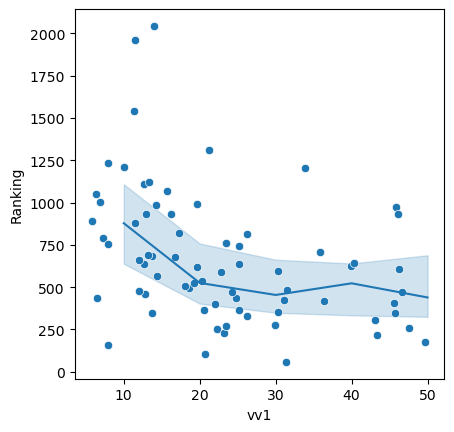

In [52]:
sns.lineplot(
    data = (ds2.assign(vv1=lambda d: (d['vv']/10).round()*10)),
    x = 'vv1',
    y = 'Ranking',
    estimator='median',
    errorbar=('pi', 50),
)

sns.scatterplot(
    data = (ds2.assign(vv1=lambda d: (d['vv']/10).round()*10)),
    x = 'vv',
    y = 'Ranking',
    # estimator='median',
    # errorbar=('pi', 50),
)
ax:plt.Axes = plt.gca()
# ax.set_yscale('log')
ax.set_box_aspect(1)
# ax.set_ylim(100,2000)

In this graph, we do not perform a linear regression. Instead, we round the wind speeds to the nearest ten and plot the mean and the interquartile range.